In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape

In [2]:
# 2. Đọc file csv và gắng index với Price
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GBPUSDX.csv')
df = df.dropna()
df=df.reset_index()['Close']


In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Xây dựng mô hình
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Reshape((64, 1)), # Thay đổi số chiều của dữ liệu
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 4s 96ms/step - loss: 0.0299 - val_loss: 0.2058
Epoch 2/100
17/17 [==============================] - 1s 77ms/step - loss: 0.0161 - val_loss: 0.2019
Epoch 3/100
17/17 [==============================] - 1s 74ms/step - loss: 0.0149 - val_loss: 0.1878
Epoch 4/100
17/17 [==============================] - 1s 76ms/step - loss: 0.0129 - val_loss: 0.1507
Epoch 5/100
17/17 [==============================] - 1s 51ms/step - loss: 0.0079 - val_loss: 0.1139
Epoch 6/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0055 - val_loss: 0.1101
Epoch 7/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0043 - val_loss: 0.1008
Epoch 8/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0034 - val_loss: 0.0931
Epoch 9/100
17/17 [==============================] - 1s 47ms/step - loss: 0.0034 - val_loss: 0.0914
Epoch 10/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0028 - val_loss: 0.0875

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 14ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# Chia train test lại
train_data1 = df[:train_size]
test_data1 = df[train_size:train_size+test_size]
val_data1 = df[train_size+test_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1)


In [14]:
# 12. Đánh giá độ chính xác thuật toán
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 0.03908656577864726
Testing RMSE: 0.05072163918195195
Validation MAPE: 2.7607607678715973
Testing MAPE: 3.4882546764963496
Validation MAE: 0.033521100443946
Testing MAE: 0.04046676586783456


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[43:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.46445724 0.45710634 0.44312938 0.46616148 0.4669306  0.46278897
 0.44987163 0.43750207 0.45995042 0.41373682 0.3645325  0.35944192
 0.36714142 0.37181147 0.38435809 0.36649956 0.39413255 0.40027445
 0.36304682 0.34521596 0.36028297 0.36288636 0.38228589 0.36585494
 0.35696303 0.3388804  0.36907252 0.36132322 0.3603217  0.33864248
 0.35992054 0.35936169 0.30438343 0.31058896 0.33059991 0.37399157
 0.39945276 0.39413255 0.37120835 0.38261235 0.40396789 0.42847183
 0.41431504 0.42943185 0.42993261 0.42010004 0.43436196 0.44346691
 0.43880239 0.45918684 0.43143488 0.46910516 0.48994057 0.48015781
 0.47349579 0.47145679 0.46054525 0.47128526 0.48834147 0.49737171
 0.46275577 0.45591946 0.46974702 0.47068767 0.47402421 0.47646437
 0.49037217 0.46680057 0.482479   0.48968051 0.50631066 0.48648507
 0.48390104 0.50945354 0.5134347  0.52649591 0.52156026 0.52486361
 0.52550823 0.49262143 0.47680743 0.49734681 0.48605347 0.48561635
 0.46611998 0.47959895 0.47222591 0.46748393 0.454

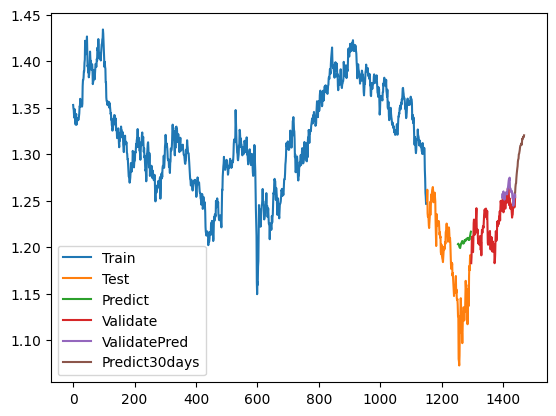

In [17]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()